In [1]:
#Pre-prep Downloads for Jupyter notebook Functioning
!pip install emoji

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler

import emoji
import string

import random
random.seed(20)
np.random.seed(20)

In [4]:
import torch

# Check GPU availability
if torch.cuda.is_available():

    # Let PyTorch use GPU
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
# Transformers package from HuggingFace
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 82.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 81.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3


In [6]:
#read in dataset in pandas format
dataset = pd.read_csv('../input/airlines-reviews-dataset/airlines_reviews.csv', sep=',')
dataset.head()

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes


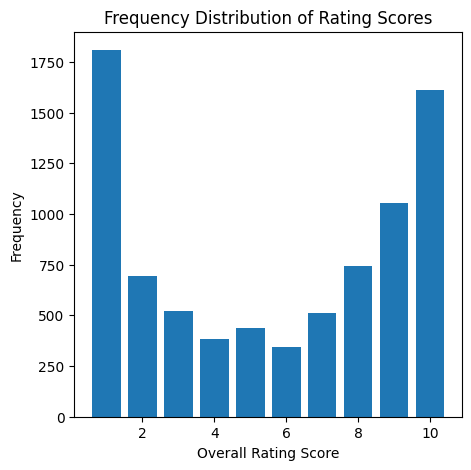

In [7]:
#Determine frequency of Overall Ratings Through Plot
freq_counts = dataset["Overall Rating"].value_counts()
rating_score = freq_counts.index

plt.figure(figsize=(5, 5))
plt.bar(rating_score, freq_counts)
plt.xlabel('Overall Rating Score')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Rating Scores')
plt.show()

In [8]:
#Create new function to convert Rating scores to 3 categories
#1-3, 4-7, 8-10 forms negative, neutral, positive [0,1,2]
def score_convert_senti(score):
    if score <= 4:
        return 0
    elif score >= 5 and score <= 6:
        return 1
    elif score >= 7:
        return 2

#Create new column, convert scoring into 3 categories
dataset["Sentiment"] = dataset["Overall Rating"].apply(score_convert_senti)

#dataset has derived sentiment column added
#dataset.head()

#dataset = dataset[dataset["Sentiment"] != 2]
dataset.head()

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Sentiment
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes,2
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no,0
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes,2
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes,2
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes,2


In [10]:
#place reviews column textual data into list
reviews = dataset["Reviews"]
reviews_list = list(reviews)

In [11]:
#check for emojis
def contain_emoji(review):
    emoList = emoji.emoji_list(review)

    if emoList:
        return True

    return False


emoji_check = [contain_emoji(review) for review in reviews_list]

for i in range(len(emoji_check)):
    if emoji_check[i] == True:
        print("This is Review: " + str(i))
        print(reviews_list[i])

This is Review: 4708
  Valerie, terminal 2A, Paris CDG airport, left our hearts feeling warm with her compassion, patience and understanding whilst checking our bags. She showed us great kindness and deserves recognition for her customer service skills performed. Thank you to Valerie, if you read this, for all the small efforts which made our travels much easier while pregnant. Thank you for going above and beyond ☺️ Turkish airlines hires great assets to their company.


In [12]:
#Since emoji is present only in review 4708, de-emojize review 4708.
reviews_list_deemojize = reviews_list.copy()
#reviews_list_deemojize[4708] = emoji.demojize(reviews_list_deemojize[4708], language='en')
#print(reviews_list[4708])
#print(reviews_list_deemojize[4708])

In [13]:
#Remove Punctuation
def remove_punc(review):
    ascii_to_translate = str.maketrans("", "", string.punctuation)
    review = review.translate(ascii_to_translate)
    return review

#print(reviews_list_deemojize[4708])
reviews_list_noPunc = [remove_punc(review) for review in reviews_list_deemojize]
#print(reviews_list_noPunc[4708])

In [14]:
#Make text all lowercase
reviews_list_lower = [review.lower() for review in reviews_list_noPunc]
#print(reviews_list_lower[4708])

In [15]:
!pip install transformers

In [17]:
bTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
'''Y = dataset["Sentiment"]
X_train, X_temp, Y_train, Y_temp = train_test_split(reviews_list_lower, Y, test_size=0.2, random_state=20)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=20)'''
Y = dataset["Sentiment"]
X_train, X_test, Y_train, Y_test = train_test_split(reviews_list_lower, Y, test_size=0.2, random_state=20)

In [20]:
#Determine frequency of sentiments in training set
print(Y_train.value_counts())
#Sample counts not even => do RandomUnderSampler

Sentiment
2    3169
0    2690
1     621
Name: count, dtype: int64


In [21]:
X_train_2d = np.array(X_train).reshape(-1, 1)
Y_train_2d = np.array(Y_train).reshape(-1, 1)

In [22]:
X_train_tok = []
#X_val_tok = []
X_test_tok = []

def encode(reviewSet, newList):
  for review in reviewSet:
    encodedReview = bTokenizer.encode_plus(
      text = review,
      add_special_tokens = True,
      max_length=512,
      truncation=True,
    )
    newList.append(encodedReview)
  return newList

X_train_tok = encode(X_train, X_train_tok)
#X_val_tok = encode(X_val, X_val_tok)
X_test_tok = encode(X_test, X_test_tok)

In [23]:
print(X_train_tok[0])
print(bTokenizer.convert_ids_to_tokens(X_train_tok[0]['input_ids']))

{'input_ids': [101, 2006, 2051, 6712, 2013, 10204, 2044, 2019, 23589, 9405, 2832, 4435, 2047, 1037, 16703, 2487, 2007, 1996, 6745, 2065, 2063, 1998, 6625, 5898, 4272, 3626, 2020, 2012, 6528, 6024, 3768, 1997, 1996, 27120, 10026, 2106, 2025, 4025, 2000, 2031, 2904, 2326, 3798, 1998, 1996, 18640, 2001, 2200, 12382, 6195, 1996, 9367, 1997, 1996, 3462, 1996, 4690, 7529, 2364, 2001, 12090, 1998, 2348, 2009, 2001, 1037, 2440, 6644, 2035, 12183, 9804, 2020, 2800, 19394, 2015, 2000, 1996, 3626, 2005, 1037, 3962, 3238, 2392, 13697, 7062, 3019, 9724, 3514, 2192, 2843, 3258, 1998, 10918, 2800, 2004, 2092, 2004, 1037, 3696, 2005, 1037, 11394, 8934, 2006, 5227, 3369, 2004, 5115, 1999, 2000, 9960, 7078, 10392, 3452, 3462, 3325, 2007, 5037, 7608, 4102, 2000, 1996, 5377, 3465, 6276, 2006, 8013, 2326, 2011, 2060, 2647, 11363, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [24]:
bModel = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3,)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
print(list(Y_train)[0])

2


In [26]:
##Create Dataloaders
BATCH_SIZE = 10

#TESTER
#Repeat for test set
X_TESTER_input = [torch.tensor(nSentence['input_ids']) for nSentence in X_train_tok[:]]
X_TESTER_input_pad = pad_sequence(X_TESTER_input, batch_first=True) [:]
X_TESTER_mask = [torch.tensor(nSentence['attention_mask']) for nSentence in X_train_tok[:]]
X_TESTER_mask_pad = pad_sequence(X_TESTER_mask, batch_first=True) [:]

Y_TESTER_input = torch.tensor(list(Y_train)[:])
TESTER_dataset = TensorDataset(X_TESTER_input_pad, X_TESTER_mask_pad, Y_TESTER_input)

#Create dataloaders
TESTER_dataLoader = DataLoader(TESTER_dataset, batch_size=BATCH_SIZE)

#Repeat for test set
X_TESTTESTER_input = [torch.tensor(nSentence['input_ids']) for nSentence in X_test_tok[:]]
X_TESTTESTER_input_pad = pad_sequence(X_TESTTESTER_input, batch_first=True) [:] #ERROR HERE, proper terms
X_TESTTESTER_mask = [torch.tensor(nSentence['attention_mask']) for nSentence in X_test_tok[:]]
X_TESTTESTER_mask_pad = pad_sequence(X_TESTTESTER_mask, batch_first=True) [:]

Y_TESTTESTER_input = torch.tensor(list(Y_test)[:])
TESTTESTER_dataset = TensorDataset(X_TESTTESTER_input_pad, X_TESTTESTER_mask_pad, Y_TESTTESTER_input)

#Create dataloaders
TESTTESTER_dataLoader = DataLoader(TESTTESTER_dataset, batch_size=BATCH_SIZE)

In [27]:
print(X_TESTER_mask_pad)
#print(X_TESTTESTER_mask_pad)
print(Y_TESTER_input)

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([2, 0, 2,  ..., 2, 2, 2])


In [28]:
#optimizer method
optimizer = torch.optim.AdamW(bModel.parameters(), lr = 1e-6,)

#epochs
EPOCHS = 10

#scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(TESTER_dataset) * EPOCHS)

#loss function
loss_function = nn.CrossEntropyLoss()

In [29]:
#Train the BERT model
outputs = 0
counter = 0
accuracyTrain_list = []
lossTrain_list = []
avg_accuracyTrain_list = []

bModel.to(device)
for i in range(EPOCHS):
  #inform model training beginning
  bModel.train()
  total_loss = 0
  total_accuracy = 0

  for item in TESTER_dataLoader:
    #restart optimizer values
    optimizer.zero_grad()
    input_ids = item[0].to(device)
    attention_masks = item[1].to(device)
    labels = item[2].to(device)

    outputs = bModel(input_ids=input_ids,
                     attention_mask=attention_masks, labels=labels)
    loss = outputs.loss
    predictions = torch.argmax(outputs.logits, dim=1)
    print(predictions)
    print(labels)
    print(loss)
    print((predictions == labels).sum().item() / predictions.size(0))
    accuracyTrain_list.append((predictions == labels).sum().item() / predictions.size(0))


    total_loss = total_loss + loss.item()
    total_accuracy += (predictions == labels).sum().item() / predictions.size(0)

    loss.backward()
    optimizer.step()
    scheduler.step()
    counter += 1
    print("pass done" + str(counter))
  average_accuracy_in_epoch = total_accuracy / len(TESTER_dataLoader)
  avg_accuracyTrain_list.append(average_accuracy_in_epoch)

  total_accuracy = 0
  print("Average Train loss is: " + str(total_loss / len(TESTER_dataLoader)))

tensor([0, 0, 0, 0, 0, 0, 0, 2, 0, 0], device='cuda:0')
tensor([2, 0, 2, 2, 0, 2, 2, 2, 1, 0], device='cuda:0')
tensor(1.0683, device='cuda:0', grad_fn=<NllLossBackward0>)
0.4
pass done1
tensor([0, 0, 0, 2, 0, 2, 2, 0, 0, 0], device='cuda:0')
tensor([0, 2, 0, 0, 2, 0, 2, 0, 2, 0], device='cuda:0')
tensor(0.9424, device='cuda:0', grad_fn=<NllLossBackward0>)
0.5
pass done2
tensor([0, 0, 0, 2, 0, 0, 0, 0, 2, 2], device='cuda:0')
tensor([2, 2, 2, 0, 0, 2, 0, 2, 2, 1], device='cuda:0')
tensor(1.0165, device='cuda:0', grad_fn=<NllLossBackward0>)
0.3
pass done3
tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([2, 0, 2, 0, 2, 0, 2, 2, 2, 0], device='cuda:0')
tensor(1.0558, device='cuda:0', grad_fn=<NllLossBackward0>)
0.5
pass done4
tensor([0, 0, 0, 0, 0, 0, 2, 0, 2, 0], device='cuda:0')
tensor([2, 0, 2, 0, 0, 2, 1, 2, 0, 2], device='cuda:0')
tensor(1.0639, device='cuda:0', grad_fn=<NllLossBackward0>)
0.3
pass done5
tensor([0, 0, 2, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([2

In [30]:
#Evaluation of Model
bModel.eval()
#total_eval_loss = 0
total_correct = 0
total_data_counter = 0
prediction_list = []
actual_list = []
accuracyTest_list = []

with torch.no_grad():
  for item in TESTTESTER_dataLoader:
    input_ids = item[0].to(device)
    attention_masks = item[1].to(device)
    labels = item[2].to(device)

    outputs = bModel(input_ids=input_ids,
                     attention_mask=attention_masks)
    #loss = outputs.loss

    #get maximum value of each column, set prediction to that column
    predictions = torch.argmax(outputs.logits, dim=1)

    total_correct += (predictions == labels).sum().item()
    total_data_counter += labels.size(dim=0)
    prediction_list.extend(predictions.cpu().numpy())
    actual_list.extend(labels.cpu().numpy())
    #print(prediction_list)
    #print(actual_list)

    #print(outputs.logits)
    print("predictions: " + str(predictions))
    print("labels: " + str(labels))
    accuracyTest_list.append((predictions == labels).sum().item() / predictions.size(0))
    #total_eval_loss = total_eval_loss + loss.item()
  #actual_list = np.array(actual_list)
  #prediction_list = np.array(prediction_list)
  #actual_list = np.argmax(actual_list, axis=1)
  #print(actual_list)
  f1 = f1_score(actual_list, prediction_list, average="weighted")

  #print("Average Train loss is: " + str(total_eval_loss / len(TESTTESTER_dataLoader)))
  print("Accuracy is: " + str(total_correct / total_data_counter))
  print("F1 is: " + str(f1))

predictions: tensor([0, 0, 2, 0, 0, 2, 1, 2, 0, 0], device='cuda:0')
labels: tensor([0, 2, 2, 0, 0, 2, 2, 0, 0, 2], device='cuda:0')
predictions: tensor([2, 0, 2, 2, 2, 2, 0, 2, 2, 2], device='cuda:0')
labels: tensor([2, 0, 2, 2, 1, 2, 0, 0, 2, 2], device='cuda:0')
predictions: tensor([0, 1, 2, 2, 0, 2, 2, 0, 0, 1], device='cuda:0')
labels: tensor([0, 0, 2, 2, 0, 2, 2, 0, 0, 0], device='cuda:0')
predictions: tensor([2, 0, 0, 1, 0, 0, 0, 2, 0, 0], device='cuda:0')
labels: tensor([2, 0, 0, 2, 1, 1, 0, 2, 0, 0], device='cuda:0')
predictions: tensor([1, 2, 0, 2, 0, 0, 2, 0, 0, 0], device='cuda:0')
labels: tensor([2, 1, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
predictions: tensor([0, 0, 0, 2, 0, 2, 0, 0, 0, 2], device='cuda:0')
labels: tensor([0, 0, 0, 2, 1, 2, 0, 0, 1, 2], device='cuda:0')
predictions: tensor([2, 1, 2, 1, 2, 0, 0, 0, 1, 0], device='cuda:0')
labels: tensor([2, 0, 2, 0, 2, 0, 0, 0, 1, 1], device='cuda:0')
predictions: tensor([0, 2, 0, 2, 2, 2, 0, 2, 0, 2], device='cuda:0')
